In [10]:
import os
import sys

## First let's look at our dataset and determine how it should be split up

In [2]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [11]:
## Let's make a directory within datasets to store all our files
# Choose a short string 3-5 characters to denote this particular dataset
# For this one, I chose "ribo" for the ribosomal rna.
# Make sure to set "focus" in datatype as the same string

dataset_focus = "exo"
dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [4]:
# Let's import our data_prep tools
import data_prep as dp

In [4]:
exo_df = dp.process_raw_fasta_files(*[f"r{i}.csv" for i in range(1, 6)], in_dir="/mnt/D1/caris_exosome/", out_dir=dataset_dir, input_format="caris",violin_out="exo_data_lengths")

Observed Characters: ['G', 'A', 'C', 'T']


In [7]:
exo_df.columns

Index(['sequence', 'length', 'round', 'copy_num'], dtype='object')

<img src="./exo/exo_data_lengths.png" alt="EXO Data Lengths" style="height: 50px; width:50px;"/>

In [1]:
import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

exo_df = am.fetch_data(["r2", "r3", "r4", "r5"], dir="./exo/", threads=6, molecule="dna")

exo_ct = dp.copynum_topology_faster(exo_df, ["r2", "r3", "r4", "r5"])
exo_ct.to_csv("./exo/exo_ct.csv", index=False)

Process Time 0.7338004112243652
Process Time 0.35588884353637695
Process Time 0.17561817169189453
Process Time 0.11760854721069336
Process Time 5082.692240715027


In [2]:
import pandas as pd
import numpy as np
exo_pd = pd.read_csv("./exo/exo_ct.csv")
exo_pd["mean"] = exo_pd.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["r2", "r3", "r4", "r5"]])), axis=1)
exo_pd["max"] = exo_pd.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["r2", "r3", "r4", "r5"]])), axis=1)

In [7]:
ones = exo_pd[exo_pd["mean"] >= 15.0]
max = exo_pd[exo_pd["max"] >= 40.0]
ones_max = ones[ones["max"] >= 40.0]
print(ones.index.__len__(), ones_max.index.__len__(), max.index.__len__())
print(np.sum(exo_pd["max"].values))

61112 23570 23796
16765102.0


In [8]:
# merged r2, r3, r4, r5 sequences, with max count number
dp.dataframe_to_fasta(max, "./exo/m1.fasta", count_key="max")

In [12]:
import rbm_torch.utils as utils

fasta_file = "m1.fasta"

seqs, affs, chars, q = utils.fasta_read(dataset_dir+fasta_file, "protein")
naffs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_m", scale="log", dividers=[15, 50, 80], target_scaling=[1., 1.2, 1.2], divider_type="percentile")
naffs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_m2", scale="log", dividers=[15], target_scaling=[1.2], divider_type="percentile")
dp.make_weight_file(f"{dataset_dir}{fasta_file.split('.')[0]}_m", naffs, "m")
dp.make_weight_file(f"{dataset_dir}{fasta_file.split('.')[0]}_m2", naffs, "m2")

Process Time 0.08887290954589844


In [14]:
import subprocess as sp

# no weights
os.chdir("../rbm_torch")
sp.check_call(f"python submit.py -d exo -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2", shell=True)
sp.call(f"python submit.py -d exo -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1", shell=True)
# weights
for wfile in ["m1_m.json", "m1_m2.json"]:
    sp.call(f"python submit.py -d exo -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w {wfile}", shell=True)
    sp.call(f"python submit.py -d exo -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1 -w {wfile}", shell=True)

In [ ]:
## Looking at the above graph + the length report in our out directory we see this

In [8]:
!cat "./exo/exosome_len_report.txt" | head -n 80 | tail -n 20

Removed 0 Repeat Sequences
Length: 25 Number of Sequences 94
Length: 26 Number of Sequences 151
Length: 27 Number of Sequences 194
Length: 28 Number of Sequences 299
Length: 29 Number of Sequences 447
Length: 30 Number of Sequences 697
Length: 31 Number of Sequences 1283
Length: 32 Number of Sequences 2285
Length: 33 Number of Sequences 5066
Length: 34 Number of Sequences 27616
Length: 35 Number of Sequences 1214996
Length: 36 Number of Sequences 757742
Length: 37 Number of Sequences 728110
Length: 38 Number of Sequences 679551


## We see that the majority of data is length 35. But we can get 2x the data by extending our range from length 35 to length 38. To make the data uniform in length, we will add gaps to the end of all sequences b/t 35 and 37

In [5]:
# So now we can define our datatype

# Datatype defines the basics of our data, Each datatype is specified for a group of related fasta files
# Focus - > short string specifier that gives the overall dataset we are using
# Molecule -> What kind of sequence data? currently protein, dna, and rna are supported
# id -> short string specifier ONLY for datasets which have different clustering methods (CLUSTERS ONLY)
# process -> How were the gaps added to each dataset, used to name directory (CLUSTERS ONLY)
# clusters -> How many clusters are in each data file (1 if no clusters)
# cluster_indices -> Define the lengths of data put in each cluster, It is inclusive so [12, 16] includes length 12 and length 16. There must be cluster_indices for each cluster
# gap_position_indices -> Index where gaps should be added to each sequence that is short of the maximum length. (-1 means add gaps to the end of the clusters)

exo_datatype = {"focus": "exo", "molecule": "dna", "id": None, "process": None, "clusters": 1, "gap_position_indices": [-1], "cluster_indices": [[35, 38]]}

## Before we do anything else, we need to copy our datatype to phage_display_ML/rbm_torch/analysis/global_info.py
## Also make sure to add the new datatype to the datatype_list in the same file.

## Next we need to process the raw files and make our own fasta files with our preferred formatting

In [8]:
chars_to_remove = ["W", "D", "V", "M", "B", "R", "K", "Y", "H", "S"]
chars_replace = {x: "-" for x in chars_to_remove}
dp.prepare_data_files("exo", exo_df, target_dir=dataset_dir, remove_chars=None, character_conversion=None) # Creates datafiles in target directory

## Now we have generated a data file that we can use for training our RBM or CRBM

In [9]:
!head -n 20 "./exo/r2.fasta"

>seq0-555276
GCTTGTCAACTCTACAGTGCAAAGCTAATTTTGCT---
>seq1-434762
TGTATATCCAGCGGGAGTGCGTCCAGCGTGCCGGG---
>seq2-175409
GGTGTGACTTAAAATTTGGTTTCGTTATTCCGCCATGA
>seq3-167700
GTTGCCCACTATCGTTCATAACTCTCAATGTCTGTGA-
>seq4-120928
GTGTAGCTCGGATGCTGTAGAACATTTTTTTTGCGA--
>seq5-81378
ATTGATAATGTATGTTAACCCGTTTCGTTCTCCGTA--
>seq6-34574
CTAACTCTATTGACTGCCCACAACCTTACGGTCCTA--
>seq7-8859
TTGGCGAGATCATGGAGGGCGCTCACCCATCACATTGA
>seq8-4086
GCCAGGAGCACACCACGTTGCAATGGGAATTGAGT---
>seq9-3543
TCAAGCCTACTTGAAACCTGTATAAAACCAACTAT---


# Our Last Step is to generate a dataset file, which will inform our models about the location of the data as well as other important details

In [2]:
import sys
sys.path.append("../")
import rbm_torch.global_info as gi

In [12]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [3]:
data_files = [f"r{i}.fasta" for i in range(1, 6)]
data_files.append("r5c.fasta")
gi.generate_dataset_file(data_files, gi.supported_datatypes["exo"], destination="./dataset_files/")

In [7]:
!cat "./dataset_files/exo.json"

cat: ./dataset_files/exo.json: No such file or directory


In [ ]:
# We're all set to run our models now, except for creating default configs for each dataset
# Here is an example one for crbm. It should be appended to crbm_configs.py and added to all_configs

exo_default_config = {"fasta_file": "", # get's overwritten by training script anyway
          "v_num": 38,
          "q": 5,
          "molecule": "dna",
          "epochs": 100, # get's overwritten by training script anyway
          "seed": seed, # this is defined in the config file
          "batch_size": 10000, # can be raised or lowered depending on memory usage
          "mc_moves": 4,
          "lr": 0.006,
          "lr_final": None, # automatically set as lr * 1e-2
          "decay_after": 0.75,
          "loss_type": "free_energy",
          "sample_type": "gibbs",
          "sequence_weights": None,
          "optimizer": "AdamW",
          "weight_decay": 0.001,  # l2 norm on all parameters
          "l1_2": 25.0,
          "lf": 5.0,
          "ld": 10.0,
          "data_worker_num": 4
          }


In [10]:
# TO figure out the convolution topology we use some helper functions in crbm.py

# This function gives all convolutions that fully sample all visible units on the conv transpose for a given data size
from rbm_torch.utils import suggest_conv_size

# one hot encoded vector of input size (B x V X Q) is the input the CRBM uses
visible_num = 38 # V
q_states = 5 #Q
input_shape = (visible_num, q_states)
suggest_conv_size(input_shape, padding_max=2, dilation_max=1, stride_max=2)

Finding Whole Convolutions for Input with 38 inputs:
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 2, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 2, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 2, Stride: 2, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 4, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found:

## My current line of thinking is that having a dilation > 1 or a stride > 1 will introduce some position specific effects.

In [ ]:
## Idea: The size of the kernel controls defines the size of the motif/pattern of the convolutional filter. So for this dataset I expect long filters to capture the secondary structure of this rfam family

# It is possible to use different strides and dilations, but I think they only take away from the interpretability of the convolutional filters. Also, they can lead to unsampled visible units on the convolution transpose. Likewise using a hidden layer with the kernel size the same as the number of visible units is somewhat equivalent to an RBM if not exactly (I haven't verified). This introduces a positional dependence into the corresponding hidden layer of the model.

# So I will use sizes:  11, 25, 46, 86, 100, 112
# Motif Finding:  Local Features-------Global Features
# Names/Keys for hidden layers in the convolutional topology can be named anything you can use as key in a dictionary
# Model outputs are the average of each hidden layer with a set weight
exo_default_config["convolution_topology"] = {"hidden7": {"number": 10, "kernel": (7, exo_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden13": {"number": 10, "kernel": (13, exo_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden19": {"number": 15, "kernel": (19, exo_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden25": {"number": 15, "kernel": (25, exo_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                              "hidden31": {"number": 15, "kernel": (31, exo_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0}
                                             }

In [ ]:
### COPY THE ABOVE CELL TO CRBM CONFIGS AS WELL!!

In [ ]:
# Lets create a submission script for a slurm system to run using the script submit.py

# From Directory rbm_torch I ran
"python submit.py -d ribo -r all -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 --precision double"

# Use python submit.py -h for help!

In [3]:
import rbm_torch.utils as utils
import data_prep as dp
import numpy as np

In [5]:
## Now we will make a weight file, one standardized and one with negative weights
all_fasta_files = [f"r{i}.fasta" for i in range(1, 6)]
all_affinities =[]
min_vals = []
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./exo/{fasta_file}", "dna", threads=12)
    # stand_affs = dp.standardize_affinities(affs, out_plot=f"./exo/{fasta_file.split('.')[0]}_stand_affs")

    stand_affs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_sp", scale="linear", dividers=[15, 50, 80], target_scaling=[2., 20., 5.], divider_type="percentile", negate_index=1, splitter=[0.02, 0.5])

    # min_vals.append(min(stand_affs))
    # all_affinities.append(stand_affs)
    # dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_st_weights", stand_affs, "st")

    # stand2_affs = [x if x > 4 else x/1000 for x in stand_affs]
    # dp.quick_hist(stand2_affs, f"./exo/{fasta_file.split('.')[0]})st2_affs.png", bins=100)

    # dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_sd_weights", stand_affs, "sd")
    dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_sp_weights", stand_affs, "sp")

    # dataset = zip(seqs, stand_affs)
    # stand_affs = [(x, a)  for x, a in dataset if min_vals[-1] < a]
    # nseqs, naffs = zip(*stand_affs)
    # dp.write_fasta(nseqs, naffs, "./exo/exosome_enriched.fasta")



Process Time 2.909881114959717
Process Time 0.3979940414428711
Process Time 0.25513148307800293
Process Time 0.1415846347808838
Process Time 0.09172296524047852


In [3]:
import rbm_torch.utils as utils
import data_prep as dp

fasta_file = "r5c.fasta"

seqs, affs, chars, q = utils.fasta_read(f"./exo/{fasta_file}", "dna", threads=12)
stand_affs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_lo", scale="linear", dividers=[10, 40, 80], target_scaling=[1., 2., 2.], divider_type="percentile")

dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_lo_weights", stand_affs, "lo")

Process Time 0.005297183990478516


In [4]:
thresholds = min_vals
for fid, fasta_file in enumerate(all_fasta_files):
    new_weights = dp.negate_affinites(all_affinities[fid], thresholds[fid], out_plot=f"./exo/{fasta_file.split('.')[0]}_nw_affs", negative_factor=100.)
    dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_nw_weights", new_weights, "nw")

In [5]:
import subprocess as sp
os.chdir("../rbm_torch/")
sp.check_call(f"python submit.py -d exo -r r5c -p wzhengpu1 -q wildfire -g 1 -e 200 -c 6 --precision single -m crbm -w r5c_lo_weights.json", shell=True)

0

In [5]:
import os
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [6]:
#### Now we just need to generate the submission script
# run from phage_display/rbm_torch/
import subprocess as sp
import os


# weight_files = [f"r{i}_st_weights.json" for i in range(1, 6)]
weight_files = [f"r{i}_sp_weights.json" for i in range(1, 6)]
rounds = [f"r{i}" for i in range(1,6)]

os.chdir("../rbm_torch/")
for i in range(5):
    # crbm models
    sp.check_call(f"python submit.py -d exo -r {rounds[i]} -p wzhengpu1 -q wildfire -g 2 -e 200 -c 6 --precision single -m crbm -w {weight_files[i]}", shell=True)
    # rbm models
    sp.check_call(f"python submit.py -d exo -r {rounds[i]} -p wzhengpu1 -q wildfire -g 1 -e 200 -c 6 --precision single -m rbm -w {weight_files[i]}", shell=True)


## Creating Submission Scripts for HPC Slurm Jobs using submit.py script

In [ ]:
# run from phage_display_ML/rbm_torch/
!python submit.py -d exo -r exosome -w exosome_nw_weights.json -p wzhengpu1 -q wildfire -g 2 -e 200 -c 8 --precision single -m crbm
!python submit.py -d exo -r exosome -w exosome_st_weights.json -p wzhengpu1 -q wildfire -g 2 -e 200 -c 8 --precision single -m crbm

In [20]:
print("hi")

hi


In [6]:
import numpy as np
import data_prep as dp
m1_close_neighs = dp.load_neighbor_file("./exo/m1.fasta_10_neighbor_counts.pkl")
m1_far_neighs = dp.load_neighbor_file("./exo/m1.fasta_20_neighbor_counts.pkl")

neigh_avg = np.asarray(m1_close_neighs)+np.asarray(m1_far_neighs)/2

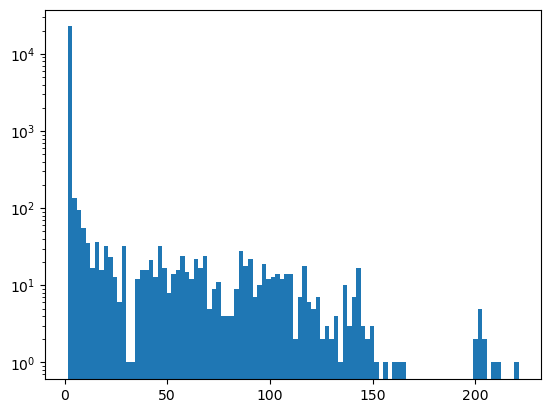

In [8]:
dp.quick_hist(neigh_avg)

In [9]:
dp.make_weight_file("m1_ne", (1/neigh_avg).tolist(), "ne", dir="./exo/")

In [10]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d exo -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w m1_ne.json --precision single", shell=True) # weights

0

Process Time 0.0036623477935791016


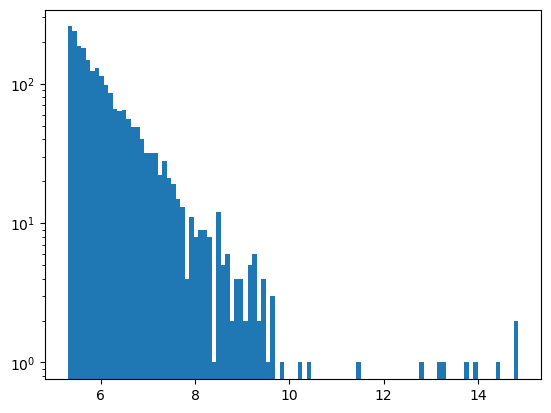

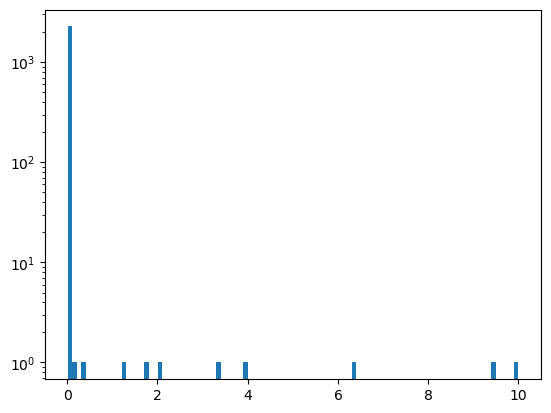

In [18]:
import numpy as np
import data_prep as dp
import rbm_torch.utils.utils as utils

fasta_file = "m1c.fasta"

seqs, affs, chars, q = utils.fasta_read(f"./exo/{fasta_file}", "dna", threads=12)
# stand_affs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_lo", scale="linear", dividers=[10, 40, 80], target_scaling=[1., 2., 2.], divider_type="percentile")
log_affs = dp.log_scale(affs, base=0.001)
lin_affs = dp.scale_values_np(np.asarray(affs), min=0.01, max=10)
dp.quick_hist(log_affs)
dp.quick_hist(lin_affs)

dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_lg", log_affs.tolist(), "lg")
dp.make_weight_file(f"./exo/{fasta_file.split('.')[0]}_ln", lin_affs.tolist(), "ln")

In [14]:
os.chdir("../datasets")

In [19]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d exo -r m1c -p wzhengpu1 -q wildfire -m crbm -e 200 -g 1 -w m1c_lg.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d exo -r m1c -p wzhengpu1 -q wildfire -m crbm -e 200 -g 1 -w m1c_ln.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d exo -r m1c -p wzhengpu1 -q wildfire -m crbm -e 200 -g 1 --precision single", shell=True) # no weights

0